In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

In [2]:
PATH_SOURCE = "/home/jbassham/jack/data/weddell/1992_2020"
PATH_DEST = PATH_SOURCE
PATH_DEST_PLOTS = os.path.join(PATH_SOURCE,'plots_error')

In [3]:
fnam = "motion_ppv4_latlon_sh_1992_2020.npz"

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v'] # meridional ice velocity
error = data['error']
lat = data['lat']
lon = data['lon']
time_ui = data['time']

In [4]:
fnam = 'con_nimbus7_latlon_sh_1992_2020.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic']

# Shift to today
ic = ic[1:,:,:]

In [5]:
fnam = "wind_JRA55_latlon_global_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
uw = data['u']
vw = data['v']

In [6]:
# Shift ice velocity and wind data forward one day to match predictions

ui = ui[1:,:,:]
vi = vi[1:,:,:]
error = error[1:,:,:]
time_ui = time_ui[1:]

uw = uw[1:,:,:]
vw = vw[1:,:,:]

In [7]:
# Normalize ice velocity and wind data

def norm(data):
    
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_norm = (data - data_mean)/data_std

    return data_norm

ui = norm(ui)
vi = norm(vi)
uw = norm(uw)
vw = norm(vw)

In [8]:
fnam = 'predictions_cnn_250109_2000_1992_2020.npz'

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
cnn_u_pred = data['u_pred']
cnn_v_pred = data['v_pred']
cnn_u_true = data['u_true']
cnn_v_true = data['v_true']

In [9]:
fnam = 'predictions_lr_1992_2020.npz'

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
lr_u_pred = data['u_pred']
lr_v_pred = data['v_pred']
lr_u_true = data['u_true']
lr_v_true = data['v_true']
time_lr = data['time']

In [10]:
# Get path to physical attributes
PATH_SOURCE = "/home/jbassham/jack/data/attributes"

# Load AAO data from 1992 to 2020
fnam = 'norm.daily.aao.cdas.z700.19790101_current.csv'
START_YEAR = 1992
END_YEAR = 2020

path = os.path.join(PATH_SOURCE, fnam)

df = pd.read_csv(path)

df_range = df[(df['year'] >= 1992) & (df['year'] <= 2020)]

year = df_range['year'].values
month = df_range['month'].values
day = df_range['day'].values
aao = df_range['aao_index_cdas'].values
time_aao = pd.to_datetime(df_range[['year', 'month', 'day']])

In [11]:
# Shift aao to 'today'
aao = aao[1:]

In [12]:
def do_misfit(u_true, u_pred, v_true, v_pred):
    
    misfit = np.sqrt((u_true - u_pred)**2 + (v_true - v_pred)**2)
    
    return misfit

In [13]:
def correlation(pre, tru):
    """Calculates Pearson Correlation given true 'tru' and predicted 'pre' values"""
    
    M_tru = np.nanmean(tru, axis = 0)
    M_pre = np.nanmean(pre, axis = 0)
    
    # Perason Correlation
    corr1 = np.nansum((tru - M_tru) * (pre - M_pre), axis = 0)
    corr2 = np.sqrt(np.nansum((tru - M_tru)**2, axis = 0)) * np.sqrt(np.nansum((pre - M_pre)**2, axis = 0))
    
    corr = corr1/corr2

    return corr

In [14]:
def correlation_grid_loop(x_gridded, y_single):

    ilat = np.shape(x_gridded)[1]
    ilon = np.shape(x_gridded)[2]

    corr = np.zeros((ilat, ilon))
    
    for i in range(ilat):
        for j in range(ilon):
            corr[i,j] = correlation(x_gridded[:,i,j], y_single)

    return corr 

In [15]:
lr_misfit = do_misfit(lr_u_true, lr_u_pred, lr_v_true, lr_v_pred)



/tmp/ipykernel_926270/1437189046.py:5: RuntimeWarning: Mean of empty slice
  M_pre = np.nanmean(pre, axis = 0)
/tmp/ipykernel_926270/1437189046.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2


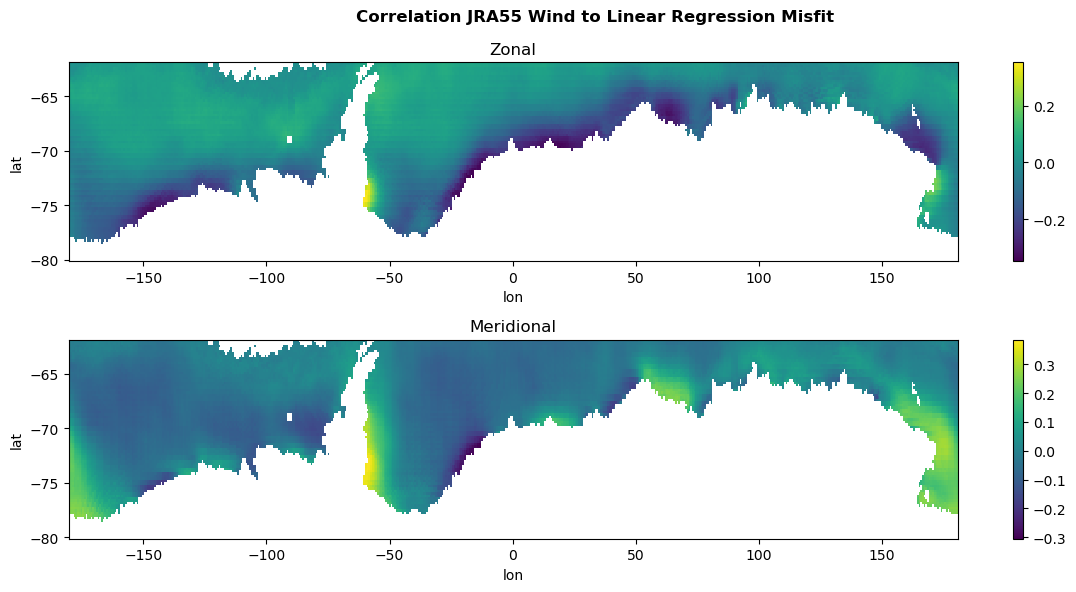

In [16]:
corr_uw_misfit = correlation(lr_misfit, uw)
corr_vw_misfit = correlation(lr_misfit, vw)

u_fig = corr_uw_misfit
v_fig = corr_vw_misfit

title = 'Correlation JRA55 Wind to Linear Regression Misfit'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fig)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Zonal')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, v_fig)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Meridional')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

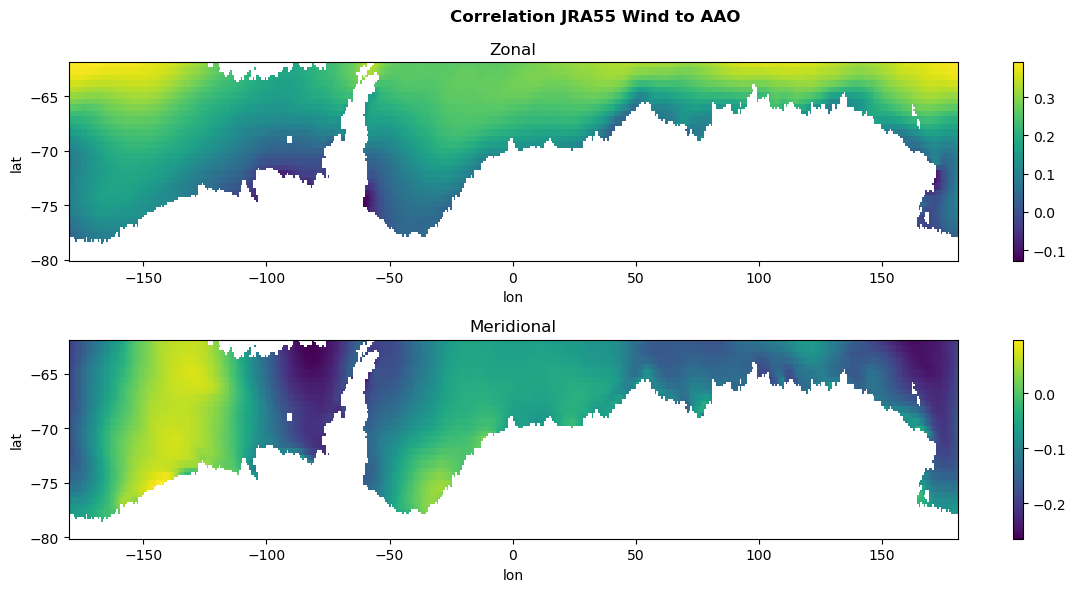

In [17]:
corr_uw_aao = correlation_grid_loop(uw, aao)
corr_vw_aao= correlation_grid_loop(vw, aao)


u_fig = np.where(np.isnan(corr_uw_misfit), np.nan, corr_uw_aao)
v_fig = np.where(np.isnan(corr_uw_misfit), np.nan, corr_vw_aao)

title = 'Correlation JRA55 Wind to AAO'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fig)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Zonal')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, v_fig)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Meridional')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

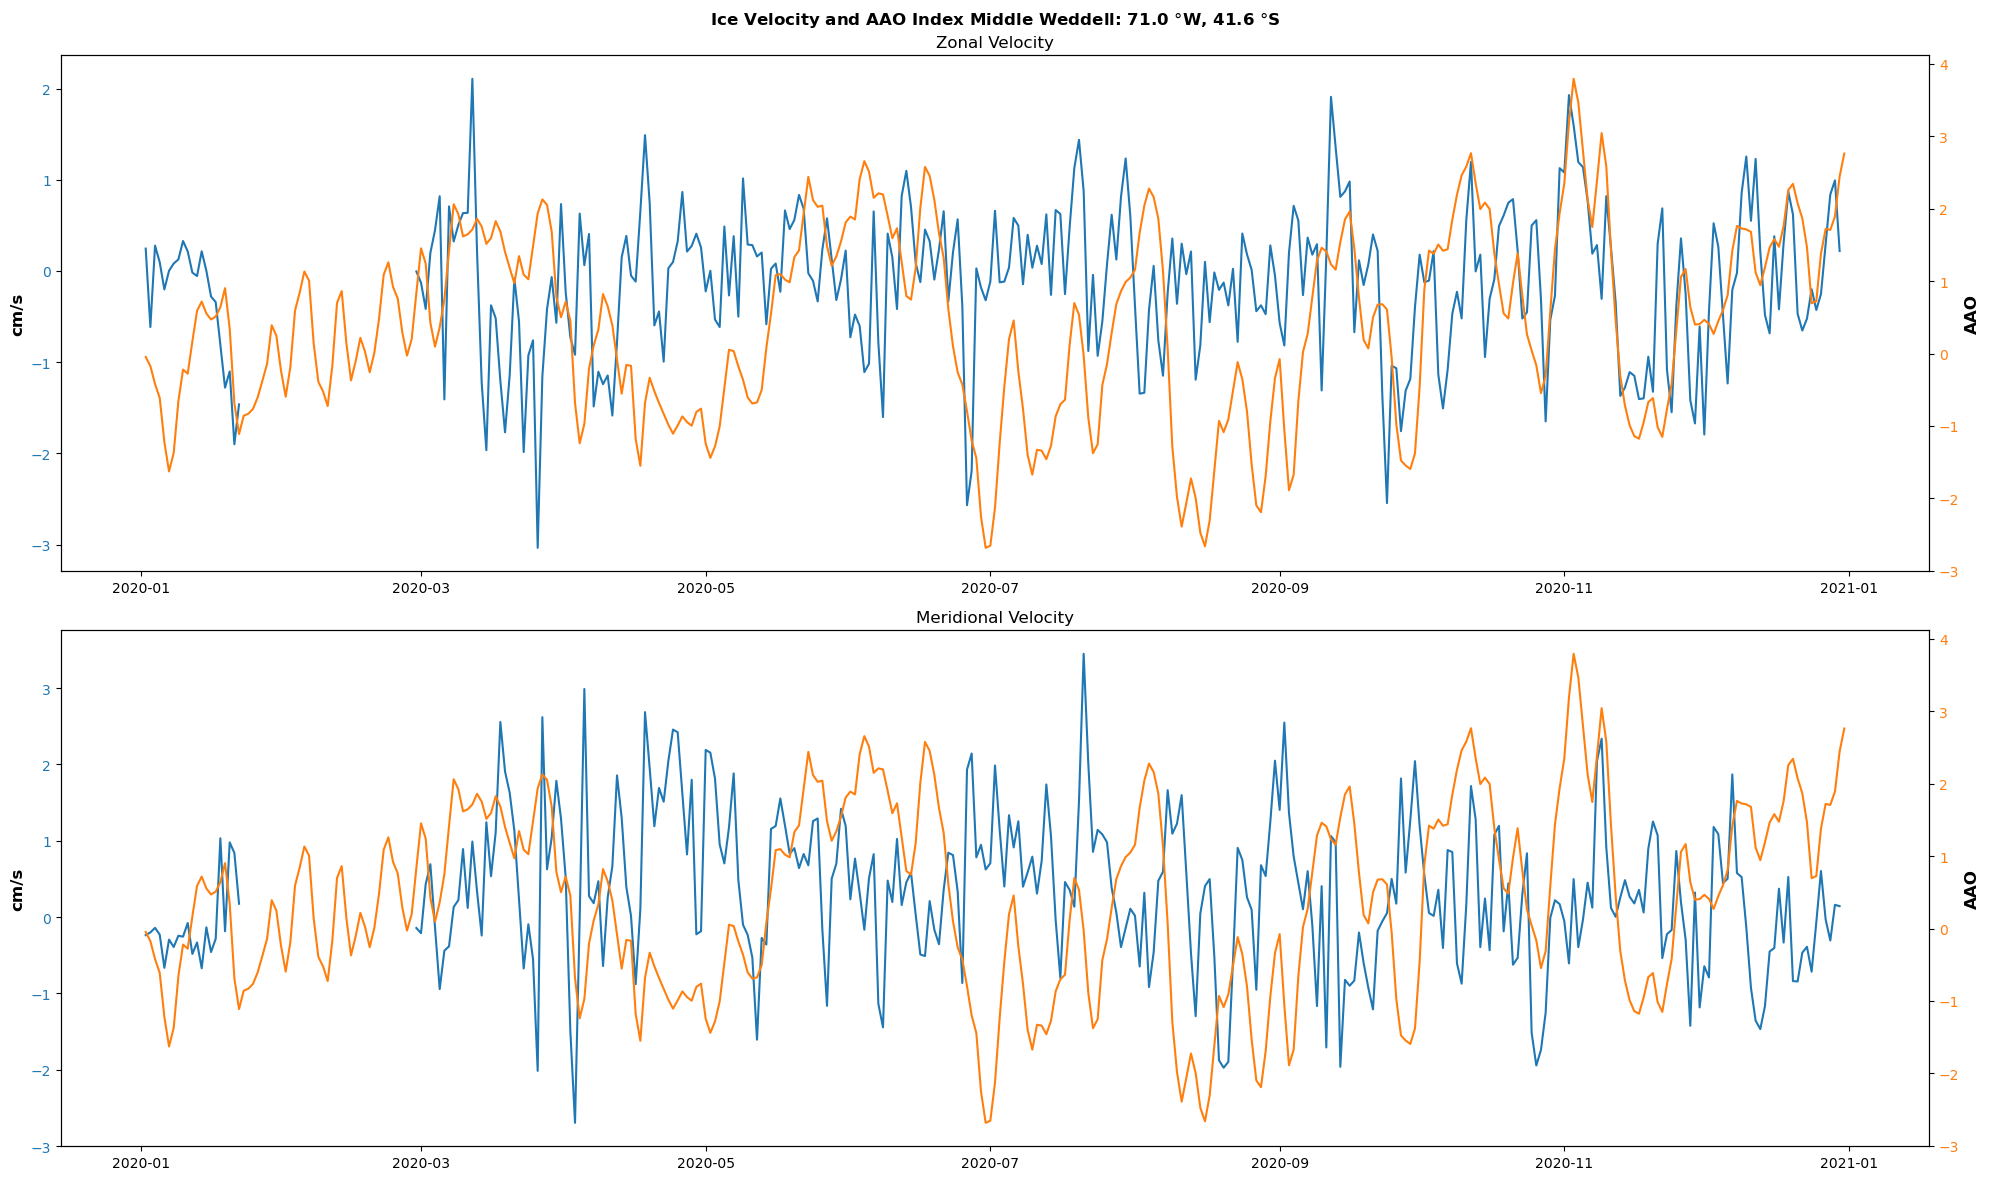

In [18]:
iy = 40
ix = 200

region = 'Middle Weddell'

if lat[iy] < 0:
    lat_str = r'$\degree $W'
else:
    lat_str = r'$\degree $E'
    
lon_str = r'$ \degree $S'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 12))

plt2 = axs[0].plot(time_ui[-365:], ui[-365:,iy,ix], label = 'zonal velocity')
axs[0].set_ylabel('cm/s', fontsize = '12', fontweight = 'bold')
axs[0].tick_params(axis='y', labelcolor = 'tab:blue')

twin2 = axs[0].twinx()
plt1 = twin2.plot(time_ui[-365:], aao[-365:], label = 'aao index', color = 'tab:orange')
twin2.tick_params(axis='y', labelcolor = 'tab:orange')
twin2.set_ylabel('AAO', fontsize = '12', fontweight = 'bold')
axs[0].set_title('Zonal Velocity')


plt4 = axs[1].plot(time_ui[-365:], vi[-365:,iy,ix], label = 'meridional velocity')
axs[1].set_ylabel('cm/s', fontsize = '12', fontweight = 'bold')
axs[1].tick_params(axis='y', labelcolor = 'tab:blue')

twin2 = axs[1].twinx()
plt3 = twin2.plot(time_ui[-365:], aao[-365:], label = 'aao index', color = 'tab:orange')
twin2.tick_params(axis='y', labelcolor = 'tab:orange')
twin2.set_ylabel('AAO', fontsize = '12', fontweight = 'bold')

axs[1].set_title('Meridional Velocity')
# twin2.legend()
# axs[1].legend

fig.suptitle(f"Ice Velocity and AAO Index {region}: {np.abs(lat[iy]):.1f} {lat_str}, {np.abs(lon[ix]):.1f} {lon_str}", fontweight = 'bold')

fig.tight_layout()
plt.show()

In [19]:
# Running mean (from Matt)

q = ui[:,iy,ix]
runmeanq = np.zeros_like(q)

N = 5 # five day rolling average
L = len(q)

for i in range(L):

    start = max(0, i - N)
    end = min(L, i + N + 1)
    
    runmeanq[i] = np.nanmean(q[start:end])

/tmp/ipykernel_926270/2884738379.py:14: RuntimeWarning: Mean of empty slice
  runmeanq[i] = np.nanmean(q[start:end])


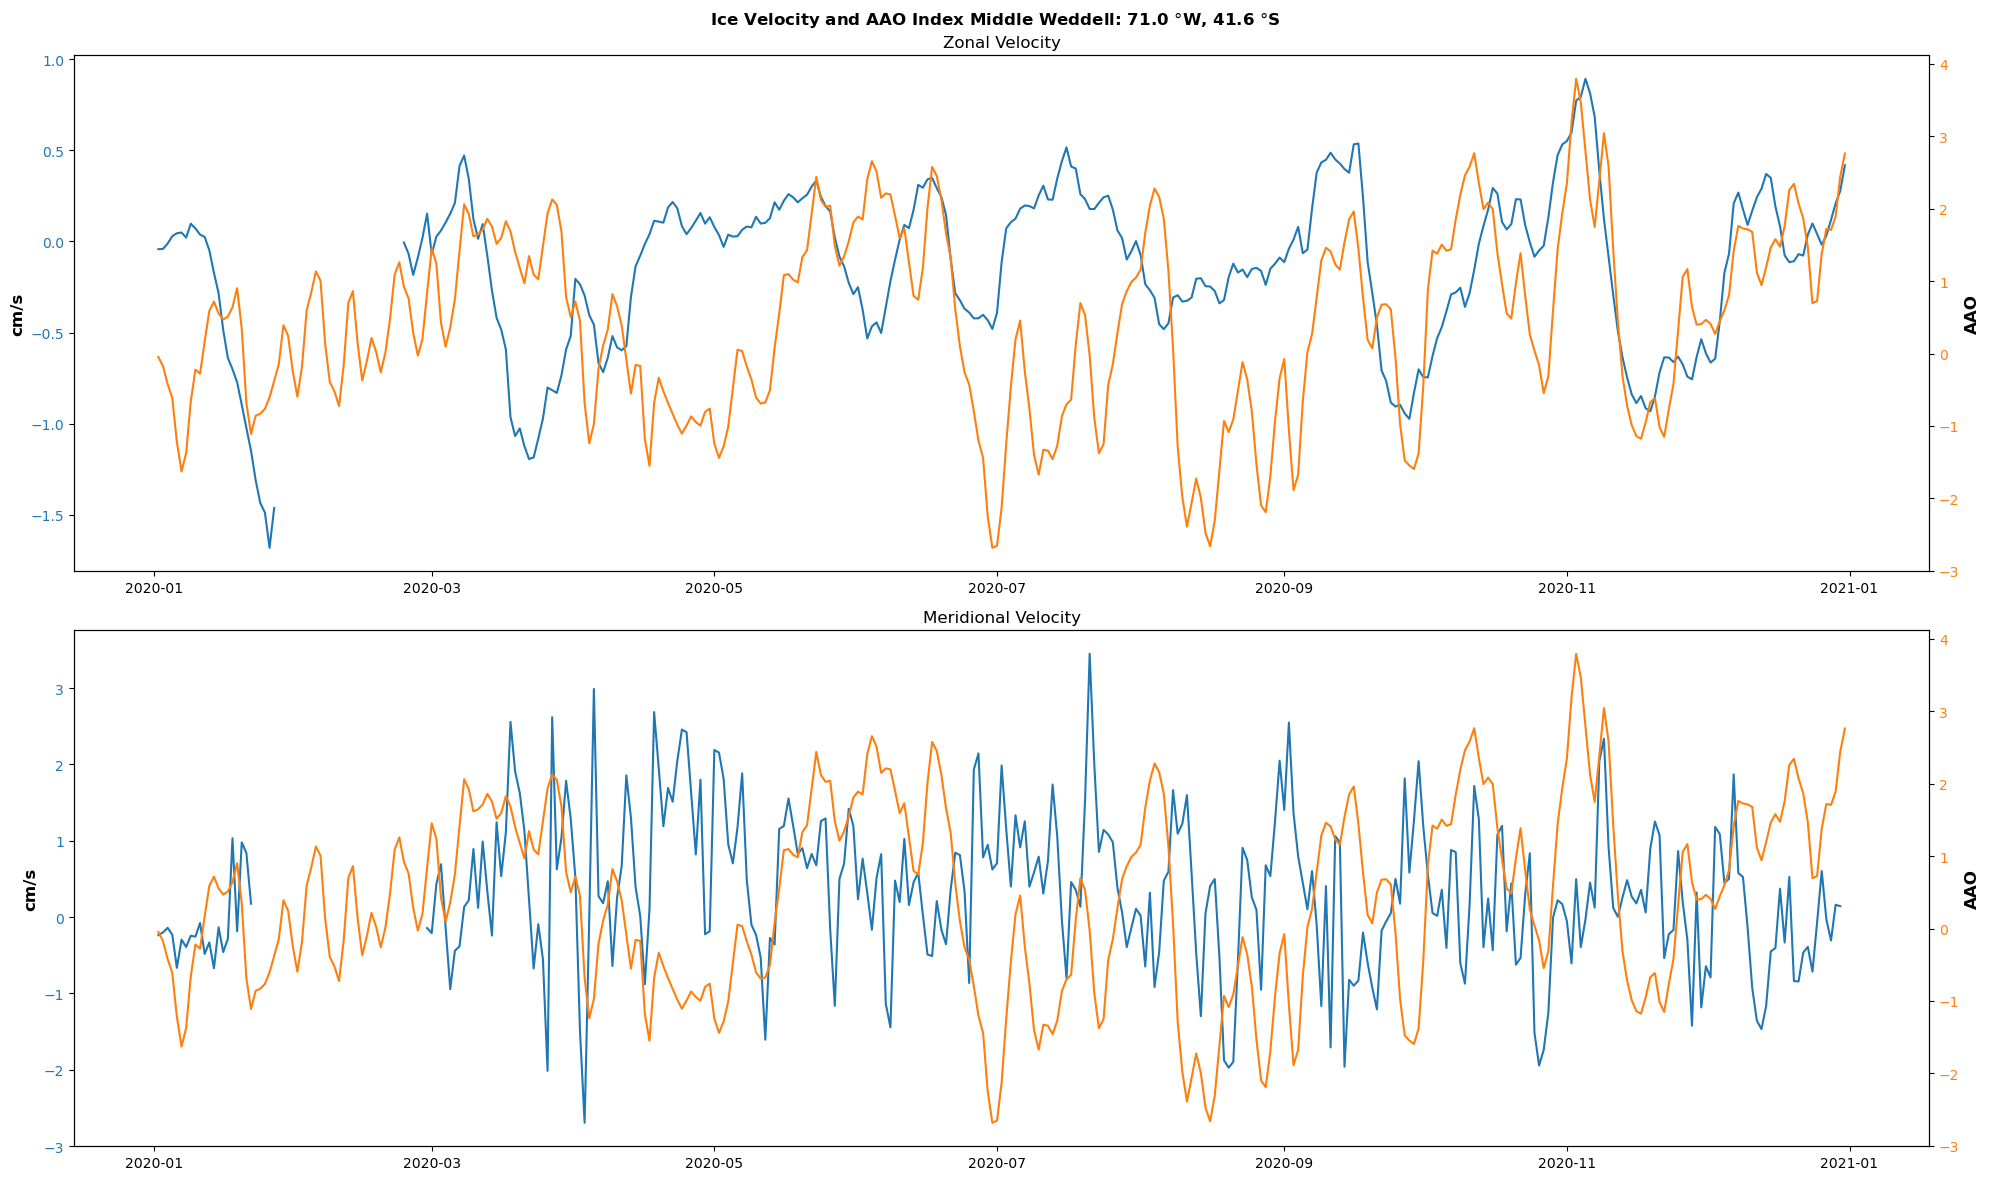

In [20]:
iy = 40
ix = 200

region = 'Middle Weddell'

if lat[iy] < 0:
    lat_str = r'$\degree $W'
else:
    lat_str = r'$\degree $E'
    
lon_str = r'$ \degree $S'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 12))

plt2 = axs[0].plot(time_ui[-365:], runmeanq[-365:], label = 'smoothed zonal velocity')
axs[0].set_ylabel('cm/s', fontsize = '12', fontweight = 'bold')
axs[0].tick_params(axis='y', labelcolor = 'tab:blue')

twin2 = axs[0].twinx()
plt1 = twin2.plot(time_ui[-365:], aao[-365:], label = 'aao index', color = 'tab:orange')
twin2.tick_params(axis='y', labelcolor = 'tab:orange')
twin2.set_ylabel('AAO', fontsize = '12', fontweight = 'bold')
axs[0].set_title('Zonal Velocity')


plt4 = axs[1].plot(time_ui[-365:], vi[-365:,iy,ix], label = 'meridional velocity')
axs[1].set_ylabel('cm/s', fontsize = '12', fontweight = 'bold')
axs[1].tick_params(axis='y', labelcolor = 'tab:blue')

twin2 = axs[1].twinx()
plt3 = twin2.plot(time_ui[-365:], aao[-365:], label = 'aao index', color = 'tab:orange')
twin2.tick_params(axis='y', labelcolor = 'tab:orange')
twin2.set_ylabel('AAO', fontsize = '12', fontweight = 'bold')

axs[1].set_title('Meridional Velocity')
# twin2.legend()
# axs[1].legend

fig.suptitle(f"Ice Velocity and AAO Index {region}: {np.abs(lat[iy]):.1f} {lat_str}, {np.abs(lon[ix]):.1f} {lon_str}", fontweight = 'bold')

fig.tight_layout()
plt.show()

In [21]:
# Correlate smoothed q
corr_ui_aao = correlation(ui[:,iy,ix], aao)
print(f'unsmoothed correlation: {corr_ui_aao}')

unsmoothed correlation: 0.13729558640795306


The effective decorrleation scale is 5
There are 2028 effective degrees of freedom from 10592 data points


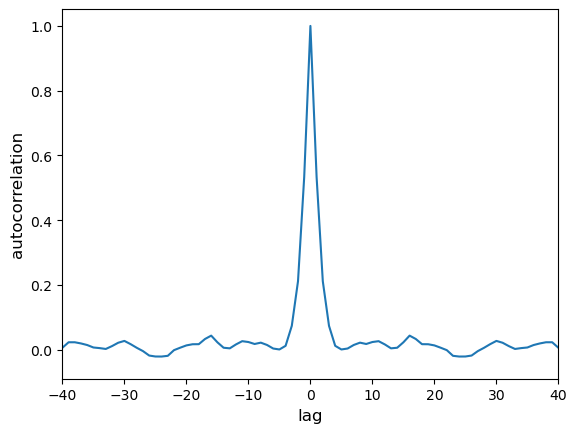

In [22]:
# Degrees of freedom unsmoothed zonal velocity
x = ui[:,iy,ix]

# Flatten x
x = x.flatten()

# Convert nans to 0 for np.correlate (nan ~ no ice)
x = np.nan_to_num(x, nan = 0)

# Remove mean from x
x = x - np.mean(x)

# Set degrees of freedom to number data points
N = len(x)

# Calculate covariance in x
xcov = np.correlate(x, x, mode = 'full')

# Plot lagged autocorrelation (normalized) in x
plt.plot(np.arange(-N+1,N),xcov/xcov[N-1])

plt.xlabel('lag', fontsize = 12)
plt.ylabel('autocorrelation', fontsize = 12)
plt.xlim(-40, 40)

L = N

T_eff = np.ones(L)

# Iterate through L's from 0 to N
for i in range(L):
    # Integrate covariance with bounds -L to L
    # T_eff[i]=np.sum(xcov[L+1-i:L-1+i])/xcov[L-1]
    T_eff[i]=np.sum(xcov[L+1-i:L-1+i])/xcov[L-1]

# Use max effecitve decorrelation scale
T_eff_max = np.max(T_eff)
print(f'The effective decorrleation scale is {int(T_eff_max)}')

# Calculate degrees of freedom, conservatively
N_eff = (N / T_eff_max)
print(f'There are {int(N_eff)} effective degrees of freedom from {N} data points')

In [23]:
corr_uismooth_aao = correlation(runmeanq, aao)
print(f'smmoothed correlation: {corr_uismooth_aao}')

smmoothed correlation: 0.21230669594900464


The effective decorrleation scale is 22
There are 465 effective degrees of freedom from 10592 data points


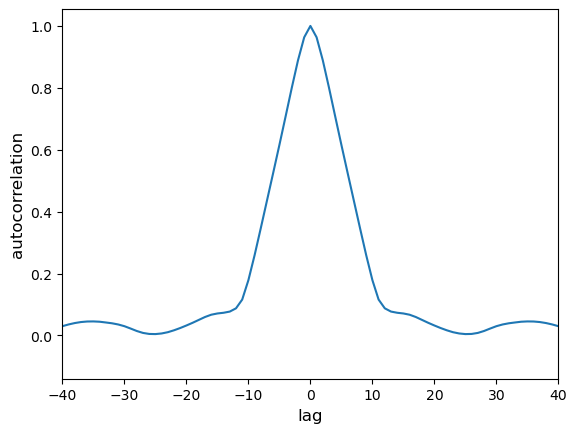

In [24]:
# Degrees of freedom smoothed zonal velocity
x = runmeanq

# Flatten x
x = x.flatten()

# Convert nans to 0 for np.correlate (nan ~ no ice)
x = np.nan_to_num(x, nan = 0)

# Remove mean from x
x = x - np.mean(x)

# Set degrees of freedom to number data points
N = len(x)

# Calculate covariance in x
xcov = np.correlate(x, x, mode = 'full')

# Plot lagged autocorrelation (normalized) in x
plt.plot(np.arange(-N+1,N),xcov/xcov[N-1])

plt.xlabel('lag', fontsize = 12)
plt.ylabel('autocorrelation', fontsize = 12)
plt.xlim(-40, 40)

L = N

T_eff = np.ones(L)

# Iterate through L's from 0 to N
for i in range(L):
    # Integrate covariance with bounds -L to L
    # T_eff[i]=np.sum(xcov[L+1-i:L-1+i])/xcov[L-1]
    T_eff[i]=np.sum(xcov[L+1-i:L-1+i])/xcov[L-1]

# Use max effecitve decorrelation scale
T_eff_max = np.max(T_eff)
print(f'The effective decorrleation scale is {int(T_eff_max)}')

# Calculate degrees of freedom, conservatively
N_eff = (N / T_eff_max)
print(f'There are {int(N_eff)} effective degrees of freedom from {N} data points')

In [25]:
def do_skill(predicted, true):

    skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
    skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
    
    # if np.isnan(skill1).any() or np.isnan(skill2).any() or (skill2 == 0).any:
    #     print("Nan in skill")
    
    skill = 1 - skill1/skill2
    
    return skill

In [26]:
def do_skill_weighted(predicted, true, uncertainty):

    skill1 = np.nanmean(((true - predicted) / uncertainty)**2, axis = 0) # MSE
    skill2 = np.nanmean((true / uncertainty - np.nanmean(true / uncertainty, axis = 0))**2, axis = 0) # Variance in true values
    
    # if np.isnan(skill1).any() or np.isnan(skill2).any() or (skill2 == 0).any:
    #     print("Nan in skill")
    
    skill = 1 - skill1 / skill2
    
    return skill

In [27]:
def do_matt_skill(x, y):

    skill = 1 - np.nanvar(y - x, axis = 0) / np.nanvar(y, axis = 0)
    
    return skill

In [28]:
def do_matt_skill_weighted(x, y, r):

    skill = 1 - np.nanvar((y - x) / r, axis = 0) / np.nanvar(y / r, axis = 0)

    return skill

In [29]:
def do_misfit_weighted(xu, yu, xv, yv, r):
    
        misfit_weighted = np.sqrt(((xu - yu) / r)**2 + ((xv - yv / r)**2))

        return misfit_weighted

/tmp/ipykernel_926270/2930361973.py:2: RuntimeWarning: Mean of empty slice
  uc_mean = np.nanmean(error, axis = 0)
/tmp/ipykernel_926270/2930361973.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  uc_var = np.nanvar(error, axis = 0)


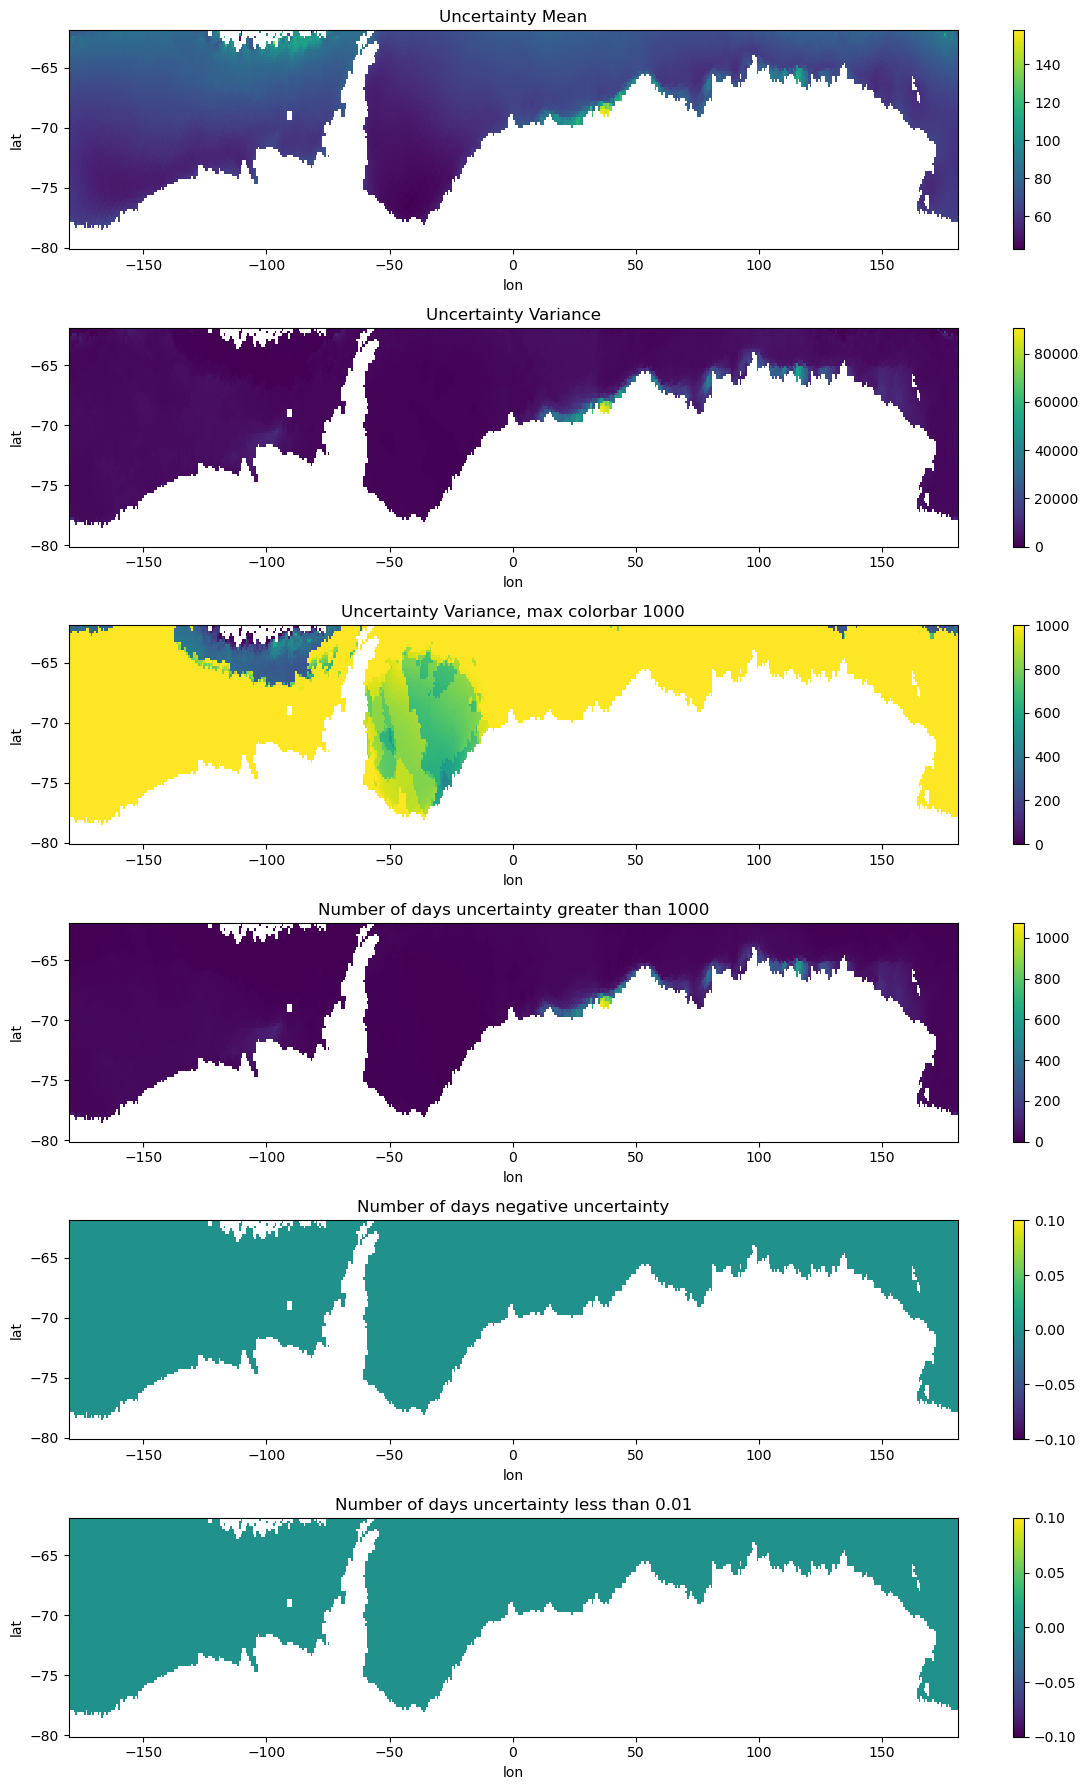

In [30]:
# Plot uncertainty
uc_mean = np.nanmean(error, axis = 0)
uc_var = np.nanvar(error, axis = 0)

n_uc_high = np.count_nonzero(error >= 1000, axis = 0)
n_uc_high = np.where(np.isnan(uc_mean), np.nan, n_uc_high)

n_uc_neg = np.count_nonzero(error < 0, axis = 0)
n_uc_neg = np.where(np.isnan(uc_mean), np.nan, n_uc_neg)

n_uc_low = np.count_nonzero(error <= 0.01, axis = 0)
n_uc_low = np.where(np.isnan(uc_mean), np.nan, n_uc_low)

fig, axs = plt.subplots(nrows = 6, ncols = 1, figsize = (12, 18))

plt0 = axs[0].pcolormesh(lon, lat, uc_mean)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Uncertainty Mean')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, uc_var)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Uncertainty Variance')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

plt2 = axs[2].pcolormesh(lon, lat, uc_var, vmax = 1000)
fig.colorbar(plt2, ax = axs[2])
axs[2].set_title('Uncertainty Variance, max colorbar 1000')
axs[2].set_xlabel('lon')
axs[2].set_ylabel('lat')

plt3 = axs[3].pcolormesh(lon, lat, n_uc_high)
fig.colorbar(plt3, ax = axs[3])
axs[3].set_title('Number of days uncertainty greater than 1000')
axs[3].set_xlabel('lon')
axs[3].set_ylabel('lat')

plt4 = axs[4].pcolormesh(lon, lat, n_uc_neg)
fig.colorbar(plt4, ax = axs[4])
axs[4].set_title('Number of days negative uncertainty')
axs[4].set_xlabel('lon')
axs[4].set_ylabel('lat')

plt5 = axs[5].pcolormesh(lon, lat, n_uc_low)
fig.colorbar(plt5, ax = axs[5])
axs[5].set_title('Number of days uncertainty less than 0.01')
axs[5].set_xlabel('lon')
axs[5].set_ylabel('lat')

# fig.suptitle('Uncertainty, Polar Pathfinder Ice Velocity Product')

fig.tight_layout()

In [31]:
x = lr_u_pred
y = lr_u_true

skill = do_skill(x, y)
skill_weighted = do_skill_weighted(x,y,error)



# fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

# plt0 = axs[0].pcolormesh(lon, lat, skill)
# fig.colorbar(plt0, ax = axs[0])
# axs[0].set_title('skill')
# axs[0].set_xlabel('lon')
# axs[0].set_ylabel('lat')

# plt1 = axs[1].pcolormesh(lon, lat, skill_weighted)
# fig.colorbar(plt1, ax = axs[1])
# axs[1].set_title('skill weighted')
# axs[1].set_xlabel('lon')
# axs[1].set_ylabel('lat')

# fig.suptitle('Zonal Velocity LR Skill')

# fig.tight_layout()

/tmp/ipykernel_926270/409690701.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
/tmp/ipykernel_926270/409690701.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
/tmp/ipykernel_926270/409690701.py:9: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2


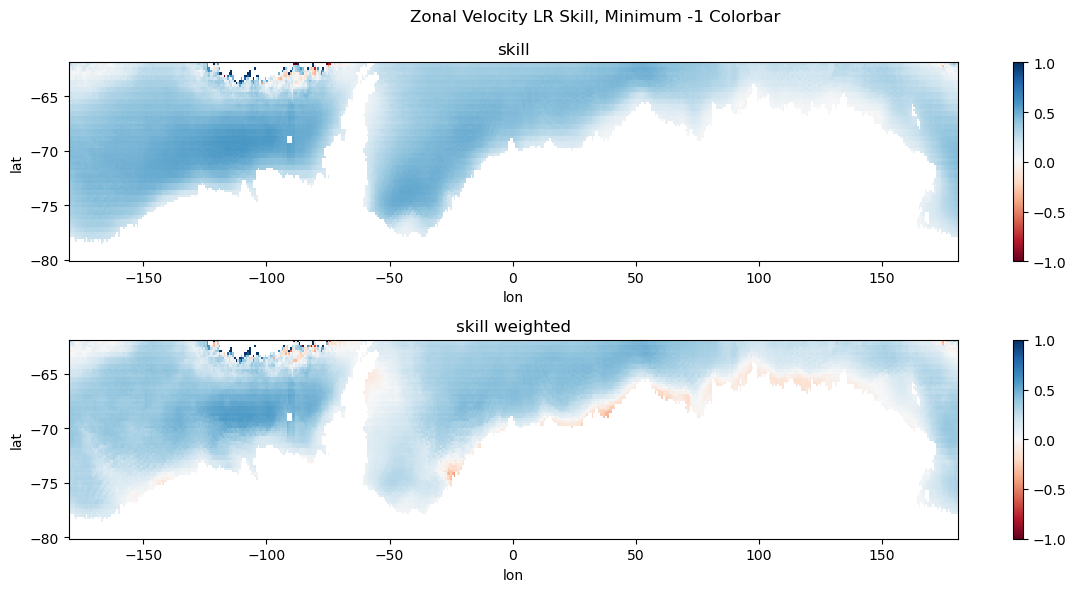

In [32]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, skill, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Zonal Velocity LR Skill, Minimum -1 Colorbar')

fig.tight_layout()

In [33]:
# Repeat with: 
    # Negative values of uncerainty flagged at 9999 (coast)
    # Minimum uncertainty 0.01 


uc_flag1 = np.where(error < 0, 9999, error)
uc_flag1 = np.where((uc_flag1 <= 0.01) | (uc_flag1 >= 1000), 9999, uc_flag1)

skill = do_skill(x, y)
skill_weighted = do_skill_weighted(x,y,uc_flag1)



# fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

# plt0 = axs[0].pcolormesh(lon, lat, skill)
# fig.colorbar(plt0, ax = axs[0])
# axs[0].set_title('skill')
# axs[0].set_xlabel('lon')
# axs[0].set_ylabel('lat')

# plt1 = axs[1].pcolormesh(lon, lat, skill_weighted)
# fig.colorbar(plt1, ax = axs[1])
# axs[1].set_title('skill weighted')
# axs[1].set_xlabel('lon')
# axs[1].set_ylabel('lat')

# fig.suptitle('Zonal Velocity LR Weighted Skill; uncertainty values (-), below 0.01, 1000 or greater flagged 9999')

# fig.tight_layout()

/tmp/ipykernel_926270/409690701.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
/tmp/ipykernel_926270/409690701.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
/tmp/ipykernel_926270/409690701.py:9: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2


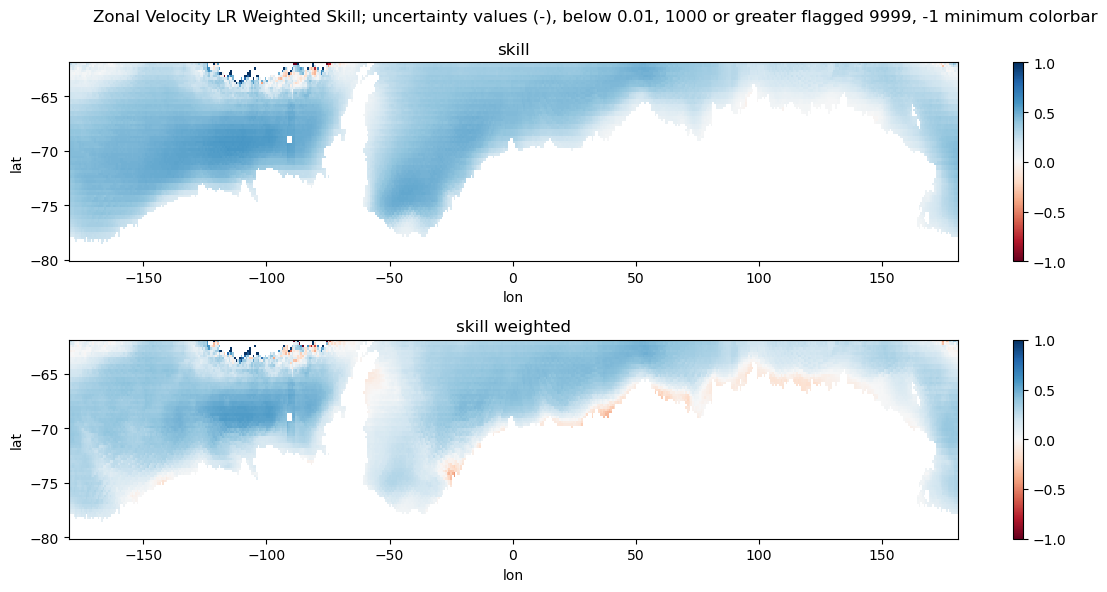

In [34]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, skill, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.suptitle('Zonal Velocity LR Weighted Skill; uncertainty values (-), below 0.01, 1000 or greater flagged 9999, -1 minimum colorbar')

fig.tight_layout()

In [35]:
# # Repeat with: 
#     # Absolute value negative values of uncerainty (coast)
#     # Greater than / equal to 1000, less than 0.01 flagged 9999


# uc_flag2 = np.abs(error)
# uc_flag2 = np.where((uc_flag2 <= 0.01) | (uc_flag2 >= 1000), 9999, uc_flag2)

# skill = do_skill(x, y)
# skill_weighted = do_skill_weighted(x,y,uc_flag2)

# fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

# plt0 = axs[0].pcolormesh(lon, lat, skill)
# fig.colorbar(plt0, ax = axs[0])
# axs[0].set_title('skill')
# axs[0].set_xlabel('lon')
# axs[0].set_ylabel('lat')

# plt1 = axs[1].pcolormesh(lon, lat, skill_weighted)
# fig.colorbar(plt1, ax = axs[1])
# axs[1].set_title('skill weighted')
# axs[1].set_xlabel('lon')
# axs[1].set_ylabel('lat')

# fig.suptitle('Zonal Velocity LR Weighted Skill; abs val uncertainty, below 0.01, 1000 or greater flagged 9999')

# fig.tight_layout()

# plt.show()

In [36]:
# fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

# plt0 = axs[0].pcolormesh(lon, lat, skill, vmin = -1)
# fig.colorbar(plt0, ax = axs[0])
# axs[0].set_title('skill')
# axs[0].set_xlabel('lon')
# axs[0].set_ylabel('lat')

# plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, vmin = -1)
# fig.colorbar(plt1, ax = axs[1])
# axs[1].set_title('skill weighted')
# axs[1].set_xlabel('lon')
# axs[1].set_ylabel('lat')

# fig.suptitle('Zonal Velocity LR Weighted Skill; abs val uncertainty, below 0.01, 1000 or greater flagged 9999, -1 minimum colorbar')

# fig.tight_layout()

# plt.show()

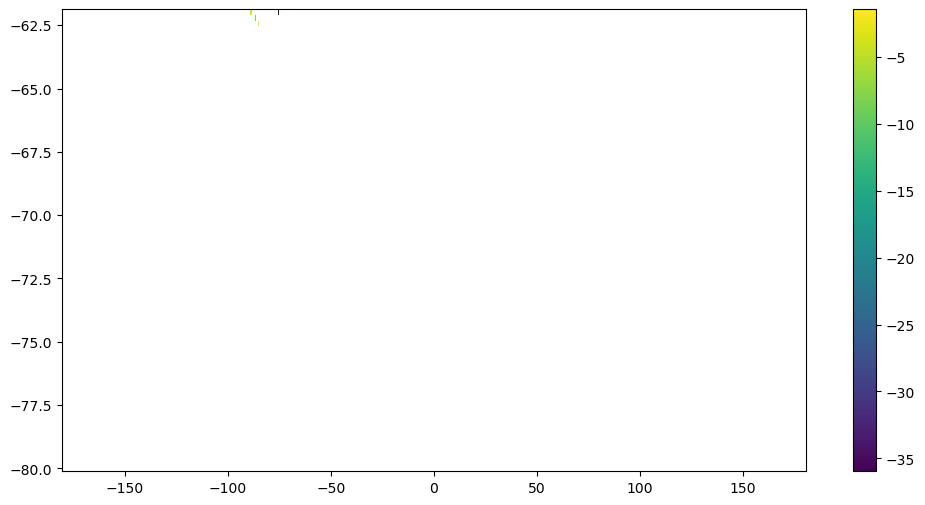

In [37]:
crazy = np.where(skill_weighted < -1, skill_weighted, np.nan)
plt.figure(figsize=(12, 6)) 
plt.pcolormesh(lon, lat, crazy)
plt.colorbar()
plt.show()

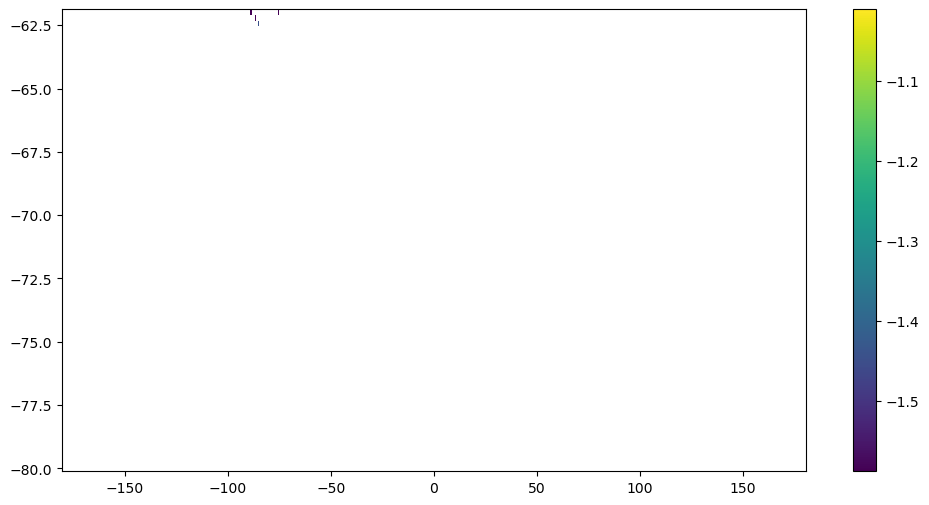

In [38]:
crazy = np.where(skill_weighted < -1, skill_weighted, np.nan)
plt.figure(figsize=(12, 6)) 
plt.pcolormesh(lon, lat, crazy, vmin = -1.01)
plt.colorbar()
plt.show()

/tmp/ipykernel_926270/2570262785.py:13: RuntimeWarning: Mean of empty slice
  plt0 = axs[0].pcolormesh(lon, lat, np.nanmean(misfit, axis = 0))
/tmp/ipykernel_926270/2570262785.py:19: RuntimeWarning: Mean of empty slice
  plt1 = axs[1].pcolormesh(lon, lat, np.nanmean(misfit_weighted, axis = 0))


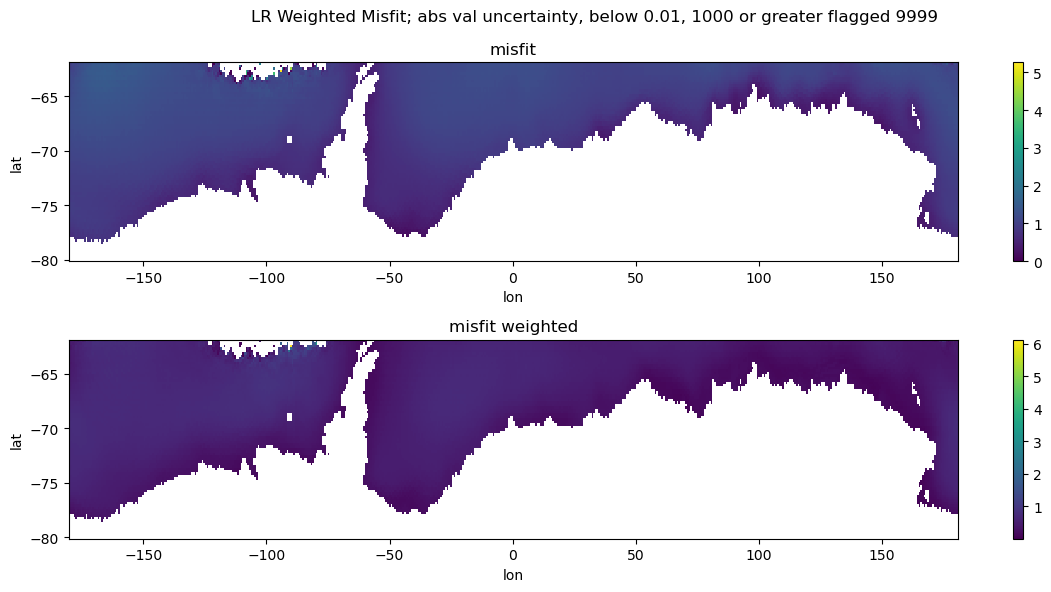

In [39]:
xu = lr_u_pred
yu = lr_u_true
xv = lr_v_pred
yv = lr_v_true



misfit = do_misfit(xu, yu, xv, yv)
misfit_weighted = do_misfit_weighted(xu, yu, xv, yv, uc_flag1)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, np.nanmean(misfit, axis = 0))
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, np.nanmean(misfit_weighted, axis = 0))
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('misfit weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('LR Weighted Misfit; abs val uncertainty, below 0.01, 1000 or greater flagged 9999')

fig.tight_layout()

plt.show()

/tmp/ipykernel_926270/1437189046.py:5: RuntimeWarning: Mean of empty slice
  M_pre = np.nanmean(pre, axis = 0)
/tmp/ipykernel_926270/1437189046.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2


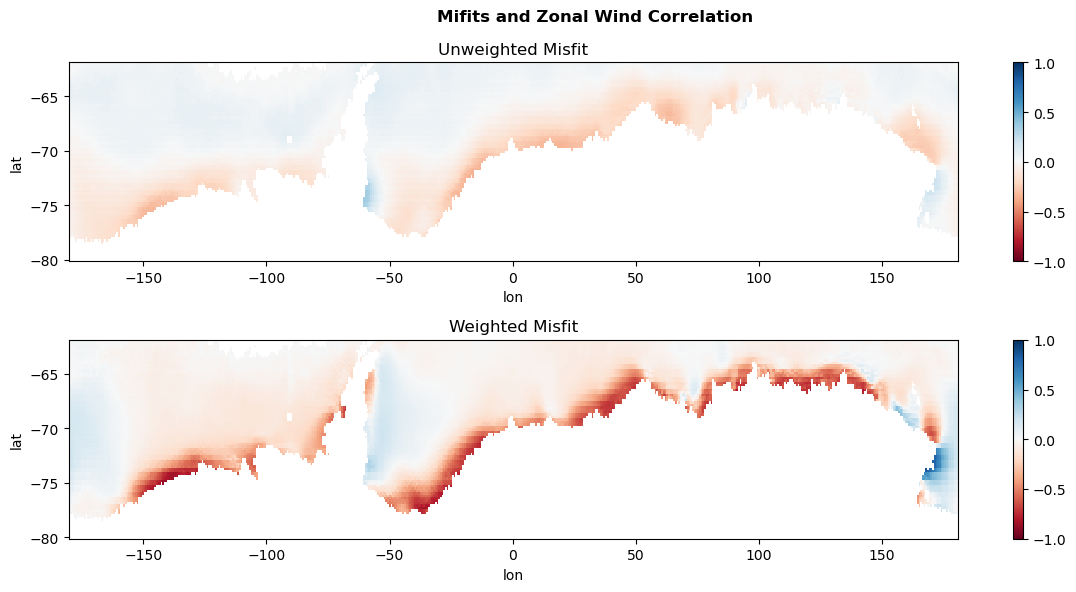

In [40]:
# Correlate weighted misfit to JRA55 wind

corr_misfit_uw = correlation(misfit, uw)
corr_misfit_weighted_uw= correlation(misfit_weighted, uw)

title = 'Mifits and Zonal Wind Correlation'

cmap = plt.cm.RdBu

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, corr_misfit_uw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Unweighted Misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, corr_misfit_weighted_uw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Weighted Misfit')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

/tmp/ipykernel_926270/1437189046.py:5: RuntimeWarning: Mean of empty slice
  M_pre = np.nanmean(pre, axis = 0)
/tmp/ipykernel_926270/1437189046.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2


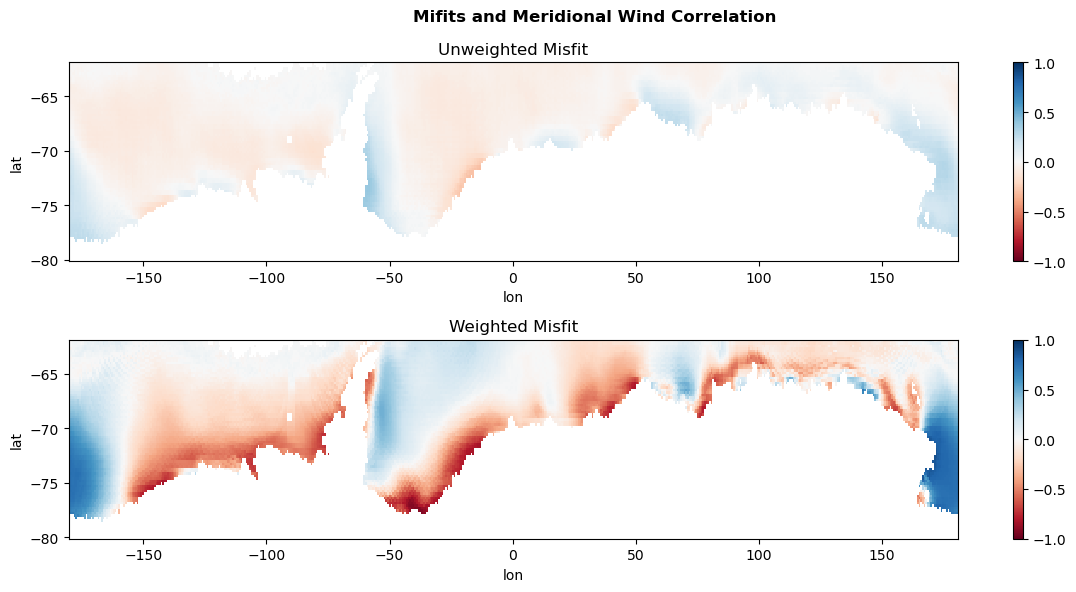

In [41]:
# Correlate weighted misfit to JRA55 wind

corr_misfit_vw = correlation(misfit, vw)
corr_misfit_weighted_vw= correlation(misfit_weighted, vw)

title = 'Mifits and Meridional Wind Correlation'

cmap = plt.cm.RdBu

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, corr_misfit_vw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Unweighted Misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, corr_misfit_weighted_vw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Weighted Misfit')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

/tmp/ipykernel_926270/1437189046.py:5: RuntimeWarning: Mean of empty slice
  M_pre = np.nanmean(pre, axis = 0)
/tmp/ipykernel_926270/1437189046.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2


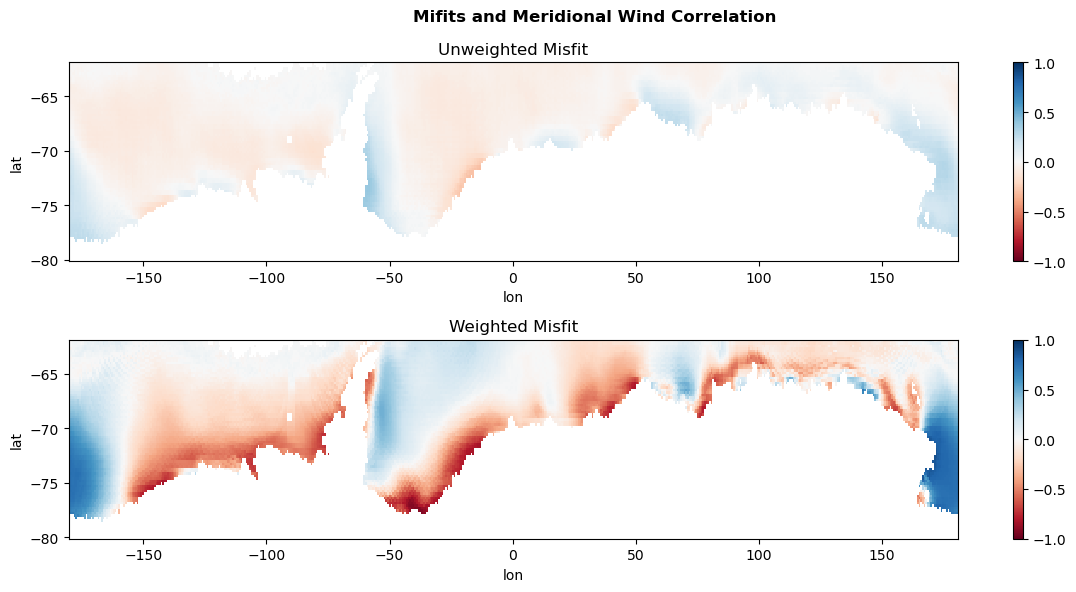

In [42]:
# Correlate weighted misfit to JRA55 wind

corr_misfit_vw = correlation(misfit, vw)
corr_misfit_weighted_vw= correlation(misfit_weighted, vw)

title = 'Mifits and Meridional Wind Correlation'

cmap = plt.cm.RdBu

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, corr_misfit_vw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Unweighted Misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, corr_misfit_weighted_vw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Weighted Misfit')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

/tmp/ipykernel_926270/1437189046.py:5: RuntimeWarning: Mean of empty slice
  M_pre = np.nanmean(pre, axis = 0)
/tmp/ipykernel_926270/1437189046.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2


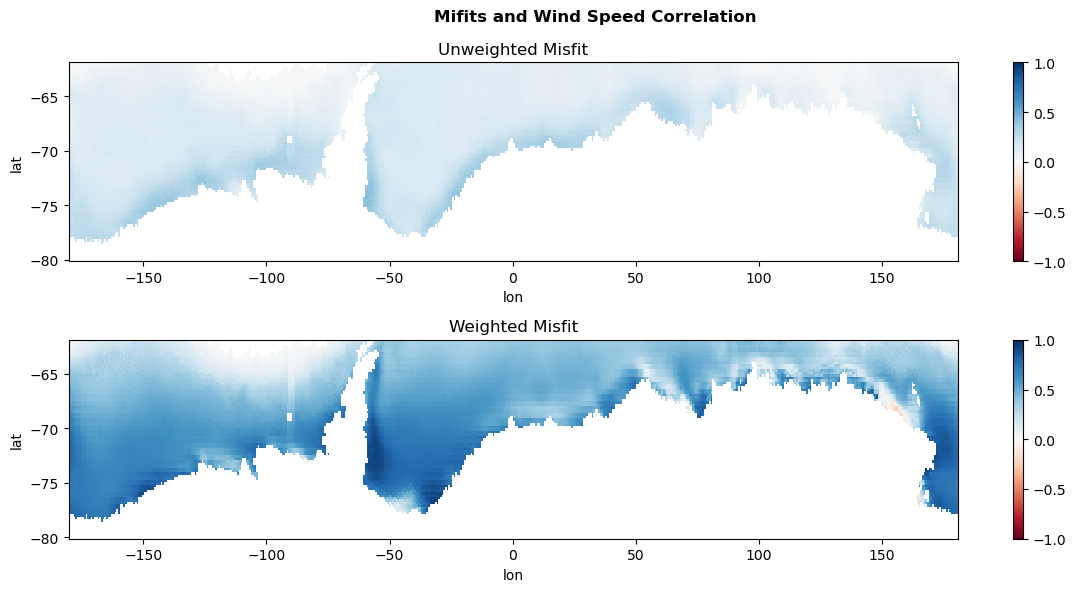

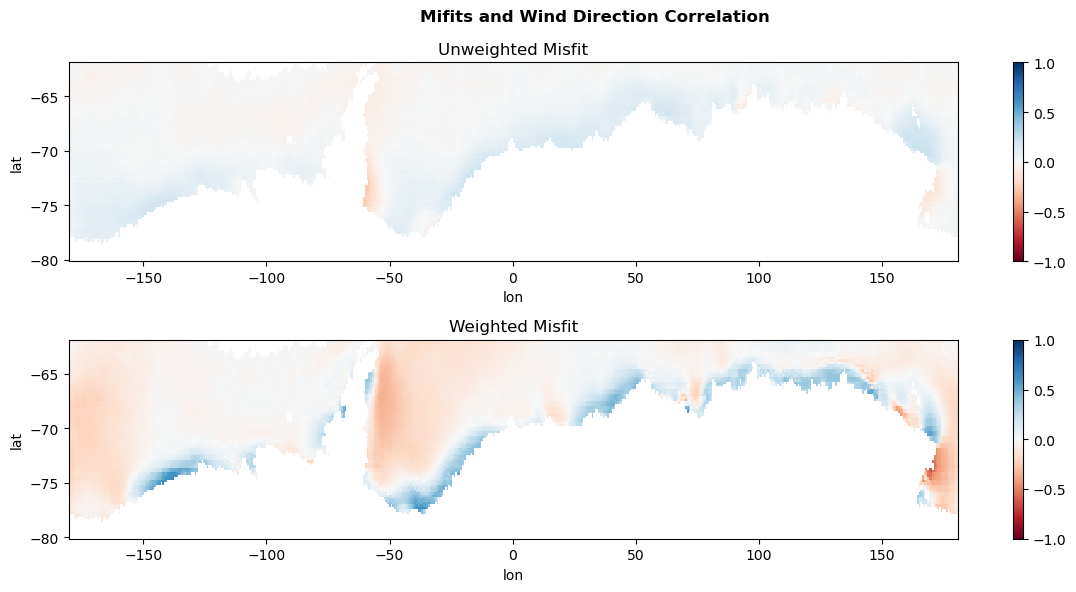

In [45]:
sw = np.sqrt(uw ** 2 + vw ** 2) # Wind speed (m/s) 

dw = np.degrees(np.arctan2(uw, vw)) # Sea ice direction (degrees)
dw = np.where(dw < 0, dw + 360, dw)

# Correlate weighted misfit to JRA55 wind speed

corr_misfit_sw = correlation(misfit, sw)
corr_misfit_weighted_sw= correlation(misfit_weighted, sw)

title = 'Mifits and Wind Speed Correlation'

cmap = plt.cm.RdBu

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, corr_misfit_sw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Unweighted Misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, corr_misfit_weighted_sw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Weighted Misfit')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

# Correlate weighted misfit to JRA55 wind direction

corr_misfit_dw = correlation(misfit, dw)
corr_misfit_weighted_dw= correlation(misfit_weighted, dw)

title = 'Mifits and Wind Direction Correlation'

cmap = plt.cm.RdBu

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, corr_misfit_dw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Unweighted Misfit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, corr_misfit_weighted_dw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Weighted Misfit')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle(title, fontweight = 'bold')

fig.tight_layout()
plt.show()

In [ ]:
# Wind speed and weighted misfit correlation

/tmp/ipykernel_926270/409690701.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
/tmp/ipykernel_926270/409690701.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
/tmp/ipykernel_926270/409690701.py:9: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2


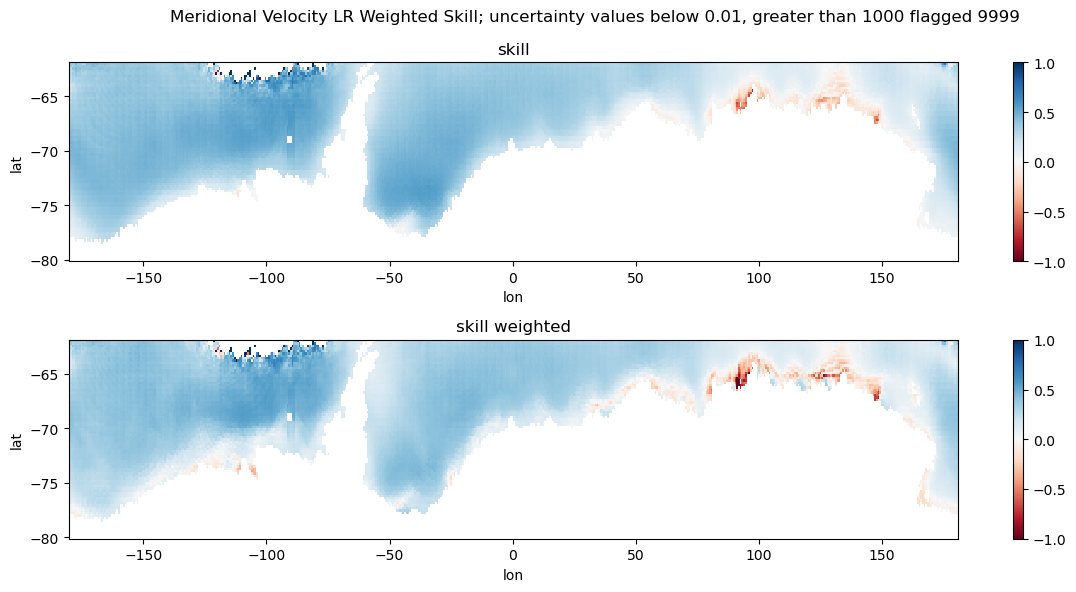

In [47]:
x = lr_v_pred
y = lr_v_true

# Negative values of uncerainty flagged at 9999 (coast)
# Minimum uncertainty 0.01 

cmap = plt.cm.RdBu

uc_flag1 = np.where(error < 0, 9999, error)
uc_flag1 = np.where((uc_flag1 <= 0.01) | (uc_flag1 >= 1000), 9999, uc_flag1)

skill = do_skill(x, y)
skill_weighted = do_skill_weighted(x,y,uc_flag1)


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, skill, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Meridional Velocity LR Weighted Skill; uncertainty values below 0.01, greater than 1000 flagged 9999')

fig.tight_layout()

2119


/tmp/ipykernel_926270/409690701.py:9: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2
/tmp/ipykernel_926270/586124234.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean(((true - predicted) / uncertainty)**2, axis = 0) # MSE
/tmp/ipykernel_926270/586124234.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true / uncertainty - np.nanmean(true / uncertainty, axis = 0))**2, axis = 0) # Variance in true values


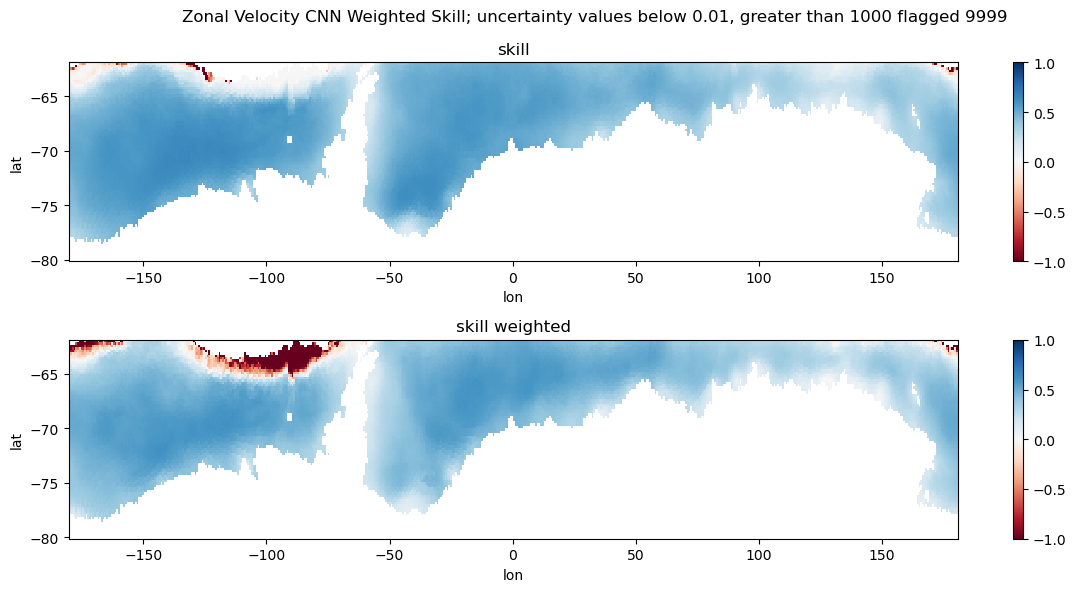

In [53]:
x = cnn_u_pred
nt_cnn = np.shape(cnn_u_pred)[0]
print(nt_cnn)
y = cnn_u_true[-nt_cnn:,:,:]



# Negative values of uncerainty flagged at 9999 (coast)
# Minimum uncertainty 0.01 

cmap = plt.cm.RdBu

uc_flag1 = np.where(error < 0, 9999, error)
uc_flag1 = np.where((uc_flag1 <= 0.01) | (uc_flag1 >= 1000), 9999, uc_flag1)

uc_flag1 = uc_flag1[-nt_cnn:,:,:]

skill = do_skill(x, y)
skill_weighted = do_skill_weighted(x,y,uc_flag1)


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, skill, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Zonal Velocity CNN Weighted Skill; uncertainty values below 0.01, greater than 1000 flagged 9999')

fig.tight_layout()

2119


/tmp/ipykernel_926270/409690701.py:9: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2
/tmp/ipykernel_926270/586124234.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean(((true - predicted) / uncertainty)**2, axis = 0) # MSE
/tmp/ipykernel_926270/586124234.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true / uncertainty - np.nanmean(true / uncertainty, axis = 0))**2, axis = 0) # Variance in true values


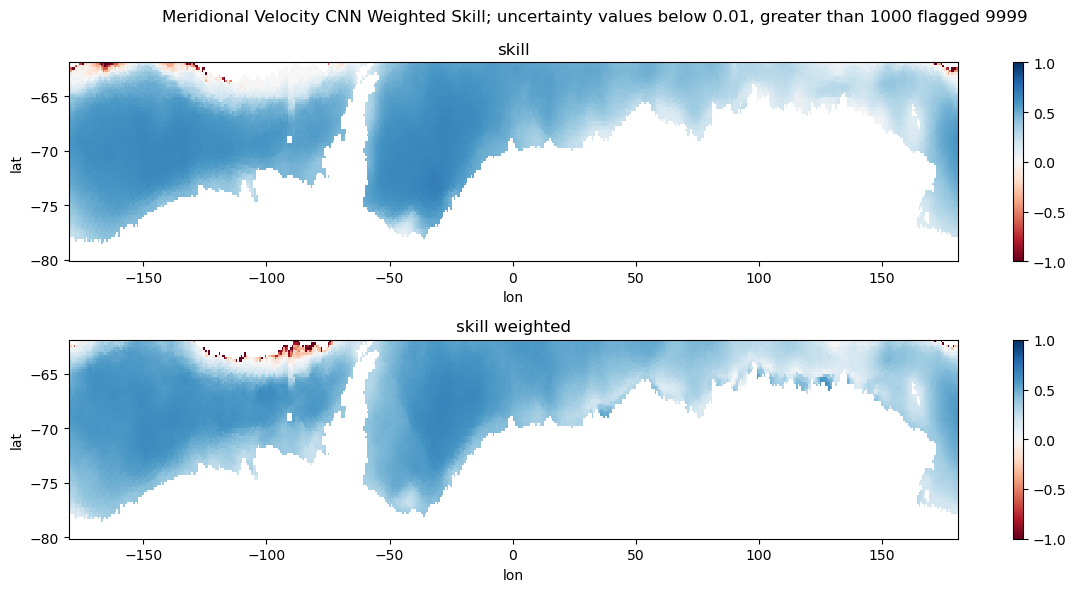

In [54]:
x = cnn_v_pred
nt_cnn = np.shape(cnn_u_pred)[0]
print(nt_cnn)
y = cnn_v_true[-nt_cnn:,:,:]



# Negative values of uncerainty flagged at 9999 (coast)
# Minimum uncertainty 0.01 

cmap = plt.cm.RdBu

uc_flag1 = np.where(error < 0, 9999, error)
uc_flag1 = np.where((uc_flag1 <= 0.01) | (uc_flag1 >= 1000), 9999, uc_flag1)

uc_flag1 = uc_flag1[-nt_cnn:,:,:]

skill = do_skill(x, y)
skill_weighted = do_skill_weighted(x,y,uc_flag1)


fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, skill, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Meridional Velocity CNN Weighted Skill; uncertainty values below 0.01, greater than 1000 flagged 9999')

fig.tight_layout()